# SOEN471-PROJECT - Suicide and Depression Sentiment Analysis - Team 13

## Librairies

In [27]:
import os
import numpy as np
import dask.dataframe as df



## Load Data

In [28]:
dask = df.read_csv(os.path.join('.', 'data', 'Suicide_Detection.csv'))
print(len(dask))

232074


## Previewing Data

In [29]:
dask.compute()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
115912,348103,If you don't like rock then your not going to ...,non-suicide
115913,348106,You how you can tell i have so many friends an...,non-suicide
115914,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
115915,348108,The usual stuff you find hereI'm not posting t...,suicide


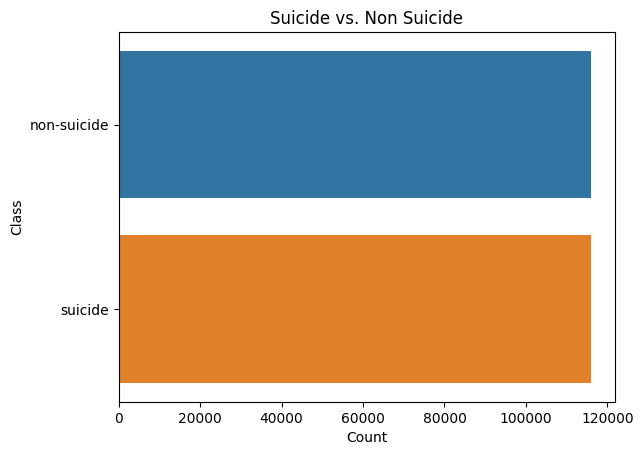

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the values in the 'column_name' column
class_counts = dask['class'].value_counts().compute()


# Create a bar plot of the value counts using Seaborn
sns.barplot(x=class_counts.values, y=class_counts.index)

# Add a title, x-label, and y-label to the plot
plt.title('Suicide vs. Non Suicide')
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()



In [49]:
dask.index

Dask Index Structure:
npartitions=2
    int64
      ...
      ...
dtype: int64
Dask Name: read-csv-index, 2 graph layers

In [34]:
counts = dask.groupby(dask.iloc[:, -1]).count().compute()

print(counts)


             Unnamed: 0    text
class                          
non-suicide      116037  116037
suicide          116037  116037


     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH